In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import TensorBoard
from time import time

data = pd.read_csv('spam.csv',encoding='latin-1')
data.head(5)

Using TensorFlow backend.


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [2]:
data = data[['v2','v1']]
data['v2'] = data['v2'].apply(lambda x: x.lower())
data['v2'] = data['v2'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
data.head(5)

,v2,v1
0,go until jurong point crazy available only in ...,ham
1,ok lar joking wif u oni,ham
2,free entry in 2 a wkly comp to win fa cup fina...,spam
3,u dun say so early hor u c already then say,ham
4,nah i dont think he goes to usf he lives aroun...,ham


In [3]:
for idx, row in data.iterrows():
    row[0] = row[0].replace('rt', ' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['v2'].values)
X = tokenizer.texts_to_sequences(data['v2'].values)
#print(X)
X = pad_sequences(X)
#print(X)
embed_dim = 128
lstm_out = 196

def createmodel():
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['v1'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3733, 152) (3733, 2)
(1839, 152) (1839, 2)


In [4]:
batch_size = 32
model = createmodel()

tensorborad = TensorBoard(log_dir="logs/{}".format(time()))

# Fit the model
history = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2,  callbacks=[tensorborad])
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
from keras.models import load_model
model.save('my_model.h5')
print(score)
print(acc)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 51s - loss: 0.1852 - accuracy: 0.9379
Epoch 2/5
 - 50s - loss: 0.0511 - accuracy: 0.9853
Epoch 3/5
 - 50s - loss: 0.0300 - accuracy: 0.9906
Epoch 4/5
 - 50s - loss: 0.0191 - accuracy: 0.9941
Epoch 5/5
 - 50s - loss: 0.0227 - accuracy: 0.9938
0.0690142278865389
0.985318124294281


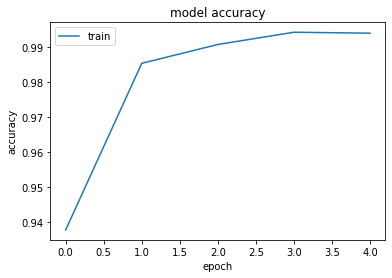

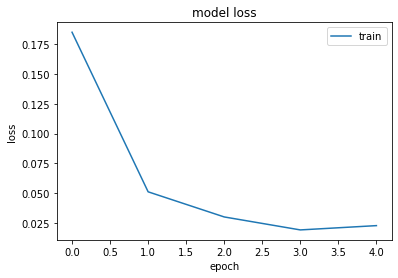

In [5]:
#accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()